In [12]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib notebook

In [13]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.post_id
    post_ids = df.post_id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.post_id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [56]:
np.random.seed(1)
datapath = Path('../data/processed/equations.csv')
df = pd.read_csv(datapath)
print('Null Data: ', df.equation.isnull().sum())
df.dropna(subset=['equation'], inplace=True)
df = df.drop_duplicates(subset=['equation', 'source'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  2
Training rows: 637850
Val rows: 67492
Test rows: 73906


In [57]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [83]:
encode_sequence('1234', tokenizer)

[1, 137, 253, 240, 354, 2]

In [87]:
tokenizer['4']

354

In [58]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.equation)

# convert string to list of int
train_df['seq'] = train_df.equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.source.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['label'] = train_df.source.map(label_map)
val_df['label'] = val_df.source.map(label_map)
test_df['label'] = test_df.source.map(label_map)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [89]:
label_map

{'biology.stackexchange.com': 2,
 'chemistry.stackexchange.com': 1,
 'physics.stackexchange.com': 0}

In [90]:
train_df.sample(10)

,equation,post_id,score,source,type,user_id,seq,length,label
1346350,[\ce{A}]_0 + [\ce{B}]_0 = [\ce{A}] + [\ce{B}] ...,62495,2,chemistry.stackexchange.com,Posts,37277.0,"[1, 40, 287, 366, 298, 200, 51, 371, 135, 320,...",92,1
1388590,\frac{\pu{0.254g} \ \ce{(NH4)3PO4}}{1} \times ...,86034,-5,chemistry.stackexchange.com,Posts,55084.0,"[1, 287, 308, 239, 182, 366, 200, 287, 271, 19...",190,1
32087,\epsilon \cdot \nabla = \sum_{j} \epsilon_{j} ...,277825,3,physics.stackexchange.com,Comments,26129.0,"[1, 287, 298, 271, 309, 251, 255, 197, 181, 14...",79,0
574396,\nabla\cdot \hat{r},291972,4,physics.stackexchange.com,Posts,39942.0,"[1, 287, 181, 182, 131, 255, 182, 287, 366, 31...",21,0
542370,"g~\in~O(26-d,10-d)",280025,-1,physics.stackexchange.com,Posts,117719.0,"[1, 38, 219, 287, 251, 181, 219, 229, 333, 253...",20,0
819030,\langle\psi|B^\dagger A^\dagger|\chi\rangle=\l...,390864,2,physics.stackexchange.com,Posts,83545.0,"[1, 287, 255, 182, 181, 38, 255, 298, 287, 271...",127,0
97893,\omega_{\text{max}},648789,0,physics.stackexchange.com,Comments,98263.0,"[1, 287, 197, 27, 298, 38, 182, 320, 200, 287,...",21,0
1368252,\mu_A=\mu_B,72599,3,chemistry.stackexchange.com,Posts,30424.0,"[1, 287, 27, 198, 320, 51, 236, 287, 27, 198, ...",13,1
1029898,x^2+z^2=R^2,474608,0,physics.stackexchange.com,Posts,169940.0,"[1, 96, 340, 253, 284, 80, 340, 253, 236, 211,...",13,0
1313808,\ce{M(HCO3)2 &lt;-&gt; MCO3 + H2O + CO2 },42181,2,chemistry.stackexchange.com,Posts,23561.0,"[1, 287, 366, 298, 200, 267, 333, 270, 226, 22...",43,1


In [59]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.class_weight =  self.compute_class_weight() if self.weight else np.ones((3,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self):
        n_classes = 3
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.label.values))


In [60]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])

batch_size = 1024
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False)


In [61]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [64]:
def clf_model(tokenizer):
    
    emb = 32
    n_kernels = 128
    kernel_width = 3
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(3, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [69]:
model = clf_model(tokenizer)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     12064       input_7[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_7[0][0]                    
__________________________________________________________________________________________________
apply_mask

In [70]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=64,
    workers=3,
    use_multiprocessing=True
)

Epoch 1/64
623/623 [==============================] - 33s 53ms/step - loss: 0.8211 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.8014 - val_sparse_categorical_accuracy: 0.6767
Epoch 2/64
623/623 [==============================] - 33s 53ms/step - loss: 0.7504 - sparse_categorical_accuracy: 0.7078 - val_loss: 0.6975 - val_sparse_categorical_accuracy: 0.6976
Epoch 3/64
623/623 [==============================] - 32s 52ms/step - loss: 0.7141 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.6014 - val_sparse_categorical_accuracy: 0.7535
Epoch 4/64
623/623 [==============================] - 33s 53ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.5632 - val_sparse_categorical_accuracy: 0.7798
Epoch 5/64
623/623 [==============================] - 33s 52ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.4974 - val_sparse_categorical_accuracy: 0.8103
Epoch 6/64
623/623 [==============================] - 33s 53ms/step - loss: 0.6216 - spars

623/623 [==============================] - 33s 53ms/step - loss: 0.2781 - sparse_categorical_accuracy: 0.8677 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.8428
Epoch 30/64
623/623 [==============================] - 33s 53ms/step - loss: 0.2537 - sparse_categorical_accuracy: 0.8744 - val_loss: 0.3916 - val_sparse_categorical_accuracy: 0.8544
Epoch 31/64
623/623 [==============================] - 33s 52ms/step - loss: 0.2528 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.8657
Epoch 32/64
623/623 [==============================] - 33s 53ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.3785 - val_sparse_categorical_accuracy: 0.8608
Epoch 33/64
623/623 [==============================] - 33s 53ms/step - loss: 0.2415 - sparse_categorical_accuracy: 0.8789 - val_loss: 0.3669 - val_sparse_categorical_accuracy: 0.8681
Epoch 34/64
623/623 [==============================] - 33s 54ms/step - loss: 0.2429 - sparse_cate

623/623 [==============================] - 33s 53ms/step - loss: 0.2126 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.4055 - val_sparse_categorical_accuracy: 0.8490
Epoch 58/64
623/623 [==============================] - 32s 52ms/step - loss: 0.1995 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.3835 - val_sparse_categorical_accuracy: 0.8611
Epoch 59/64
623/623 [==============================] - 33s 52ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.8950 - val_loss: 0.4108 - val_sparse_categorical_accuracy: 0.8459
Epoch 60/64
623/623 [==============================] - 33s 52ms/step - loss: 0.1954 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.3685 - val_sparse_categorical_accuracy: 0.8658
Epoch 61/64
623/623 [==============================] - 32s 52ms/step - loss: 0.1828 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.3749 - val_sparse_categorical_accuracy: 0.8644
Epoch 62/64
623/623 [==============================] - 33s 53ms/step - loss: 0.1770 - sparse_cate

<IPython.core.display.Javascript object>


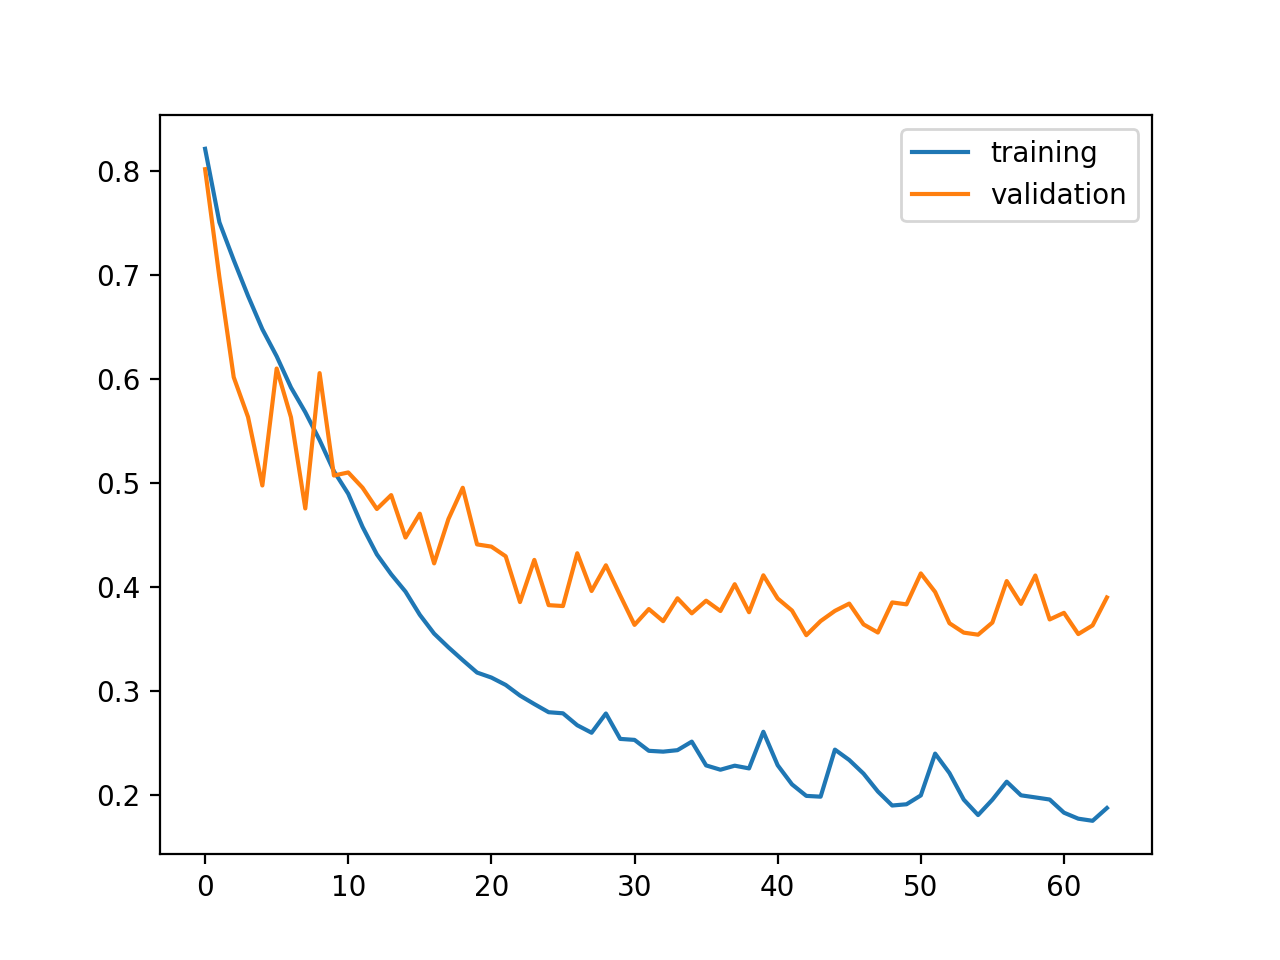

In [71]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# Evaluation

## evaluation tools

In [72]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [73]:
def predict_on_df(model, df):
    dg = DataGenerator(df, batch_size=32, shuffle=False)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['equation', 'pred_label', 'source', 'pred_index', 'label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [74]:
predictions = predict_on_df(model, val_df)


Confusion matrix, without normalization
[[51369  5759  1536]
 [ 1357  6652   330]
 [  189   148   152]]


<IPython.core.display.Javascript object>


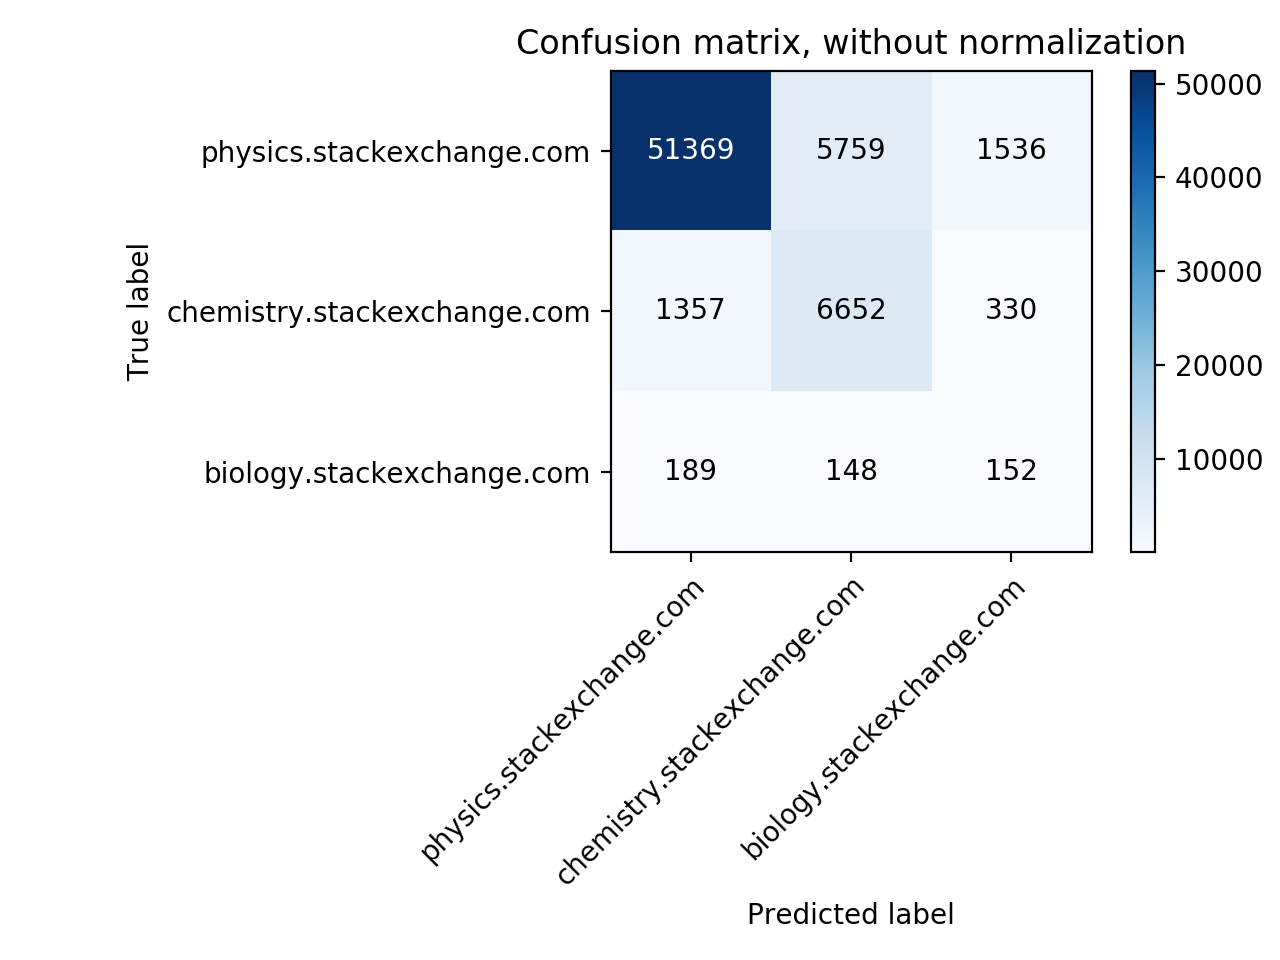

In [75]:
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(label_map.keys())))


In [94]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'label': 'physics.stackexchange.com',
 'pred_index': 0,
 'yhat': [[0.9806792736053467, 0.019320767372846603, 1.6659525321760515e-12]]}

In [77]:
display_top_losses(predictions, 100)

,equation,pred_label,source,pred_index,label,pred_conf
809103,V=q(1-q),biology.stackexchange.com,physics.stackexchange.com,2,0,0.999998
79569,\frac23 \pi r^3,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999994
860237,432000 x 100/93000000 = 0.46,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999984
565376,V_1(S)= V_2(S) = C,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999984
623380,\lambda=\frac{c}{\nu},biology.stackexchange.com,physics.stackexchange.com,2,0,0.999979
1456395,\ce{HA &lt;=&gt; H+ + A-},chemistry.stackexchange.com,biology.stackexchange.com,1,2,0.999978
1448734,\require{mhchem} \ce{[Xe] 4f^14 5d^10 6s^2 6p^2},chemistry.stackexchange.com,biology.stackexchange.com,1,2,0.999972
368024,4\pi r^2 \cdot \Delta T \cdot K,biology.stackexchange.com,physics.stackexchange.com,2,0,0.999971
424108,"k-2G, k-G, k, k+G, k+2G",biology.stackexchange.com,physics.stackexchange.com,2,0,0.999967
733757,"{{n}\choose{k}} p^{k}(1-p)^{n-k},",biology.stackexchange.com,physics.stackexchange.com,2,0,0.999967
